In [1]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PySAM.Pvsamv1 as pvsam

In [2]:
os.chdir('/Users/bstanisl/OneDrive - NREL/Documents/hybrids')

In [3]:
lat = 39.7442
lon = -105.1778
elev = 1829

In [6]:
# load system design info
system_info_file_name = '/Users/bstanisl/hercules-pysam/hercules/example_case_folders/07_amr_wind_standin_and_solar_pysam/100MW_1axis_pvsamv1.json'
with open(system_info_file_name, "r") as f:
      model_params = json.load(f)
sys_design = {
    "ModelParams": model_params,
}

model_params = sys_design["ModelParams"]


In [59]:
system_model = pvsam.new()
system_model.AdjustmentFactors.constant = 0
system_model.AdjustmentFactors.dc_constant = 0    

for k, v in model_params.items():
    try:
        system_model.value(k, v)
    except Exception:
        print(k)

air_temps = np.linspace(-20, 40, 60) # degrees C
poas = np.linspace(0., 1200., 60) # W/m2

#initialize outputs
ac = np.zeros((len(air_temps), len(poas)))
dc = np.zeros((len(air_temps), len(poas)))
dni = np.zeros((len(air_temps), len(poas)))

# iterate through parameter sweep
for a,air_temp in enumerate(air_temps):
    for i,poa in enumerate(poas):
        weather_data_input = {
            "Timestamp": ['2018-05-10 12:31:00+00:00'],
            # "SRRL BMS Direct Normal Irradiance (W/m²_irr)": [330.8601989746094],
            # "SRRL BMS Diffuse Horizontal Irradiance (W/m²_irr)": [68.23037719726561],
            # "SRRL BMS Global Horizontal Irradiance (W/m²_irr)": [68.23037719726561],
            "SRRL BMS Wind Speed at 19' (m/s)": [0.4400002620664621],
            "SRRL BMS Dry Bulb Temperature (°C)": [air_temp],
        }

        # read weather data
        data = pd.DataFrame.from_dict(weather_data_input)
        data["Timestamp"] = pd.DatetimeIndex(
                pd.to_datetime(data["Timestamp"], format="ISO8601", utc=True)
                )
        data = data.set_index("Timestamp")

        tz = data.index[0].utcoffset().total_seconds() / 60 / 60

        weather_data = np.array(
            [
                data.index.year,
                data.index.month,
                data.index.day,
                data.index.hour,
                data.index.minute,
                # data["SRRL BMS Direct Normal Irradiance (W/m²_irr)"],
                # data["SRRL BMS Diffuse Horizontal Irradiance (W/m²_irr)"],
                # data["SRRL BMS Global Horizontal Irradiance (W/m²_irr)"],
                data["SRRL BMS Wind Speed at 19' (m/s)"],
                data["SRRL BMS Dry Bulb Temperature (°C)"],
            ]
        )
        # if a==0:
        #     print(weather_data)

        solar_resource_data = {
            "tz": tz,  # timezone
            "elev": elev,  # elevation
            "lat": lat,  # latitude
            "lon": lon,  # longitude
            "year": tuple(weather_data[0]),  # year
            "month": tuple(weather_data[1]),  # month
            "day": tuple(weather_data[2]),  # day
            "hour": tuple(weather_data[3]),  # hour
            "minute": tuple(weather_data[4]),  # minute
            "poa": tuple([poa]),
            # "dn": tuple(weather_data[5]),  # direct normal irradiance
            # "df": tuple(weather_data[6]),  # diffuse irradiance
            # "gh": tuple(weather_data[7]),  # global horizontal irradiance
            "wspd": tuple(weather_data[5]),  # windspeed
            "tdry": tuple(weather_data[6]),  # dry bulb temperature
        }
        # print('wind speed = {}'.format(solar_resource_data['wspd']))
        system_model.SolarResource.irrad_mode = 3
        system_model.SolarResource.assign({"solar_resource_data": solar_resource_data})
        system_model.AdjustmentFactors.assign({"constant": 0})
        system_model.execute()
        out = system_model.Outputs.export()

        # print(a)
        # print(out["gen"][0] / 1000)
        ac[a,i] = out["gen"][0] # kW # / 1000  
        dc[a,i] = out["dc_net"][0] # kW # / 1000
        dni[a,i] = out["dn"][0]

subarray1_shading_en_string_option
subarray1_shading_en_timestep
subarray1_shading_en_diff
enable_subhourly_clipping


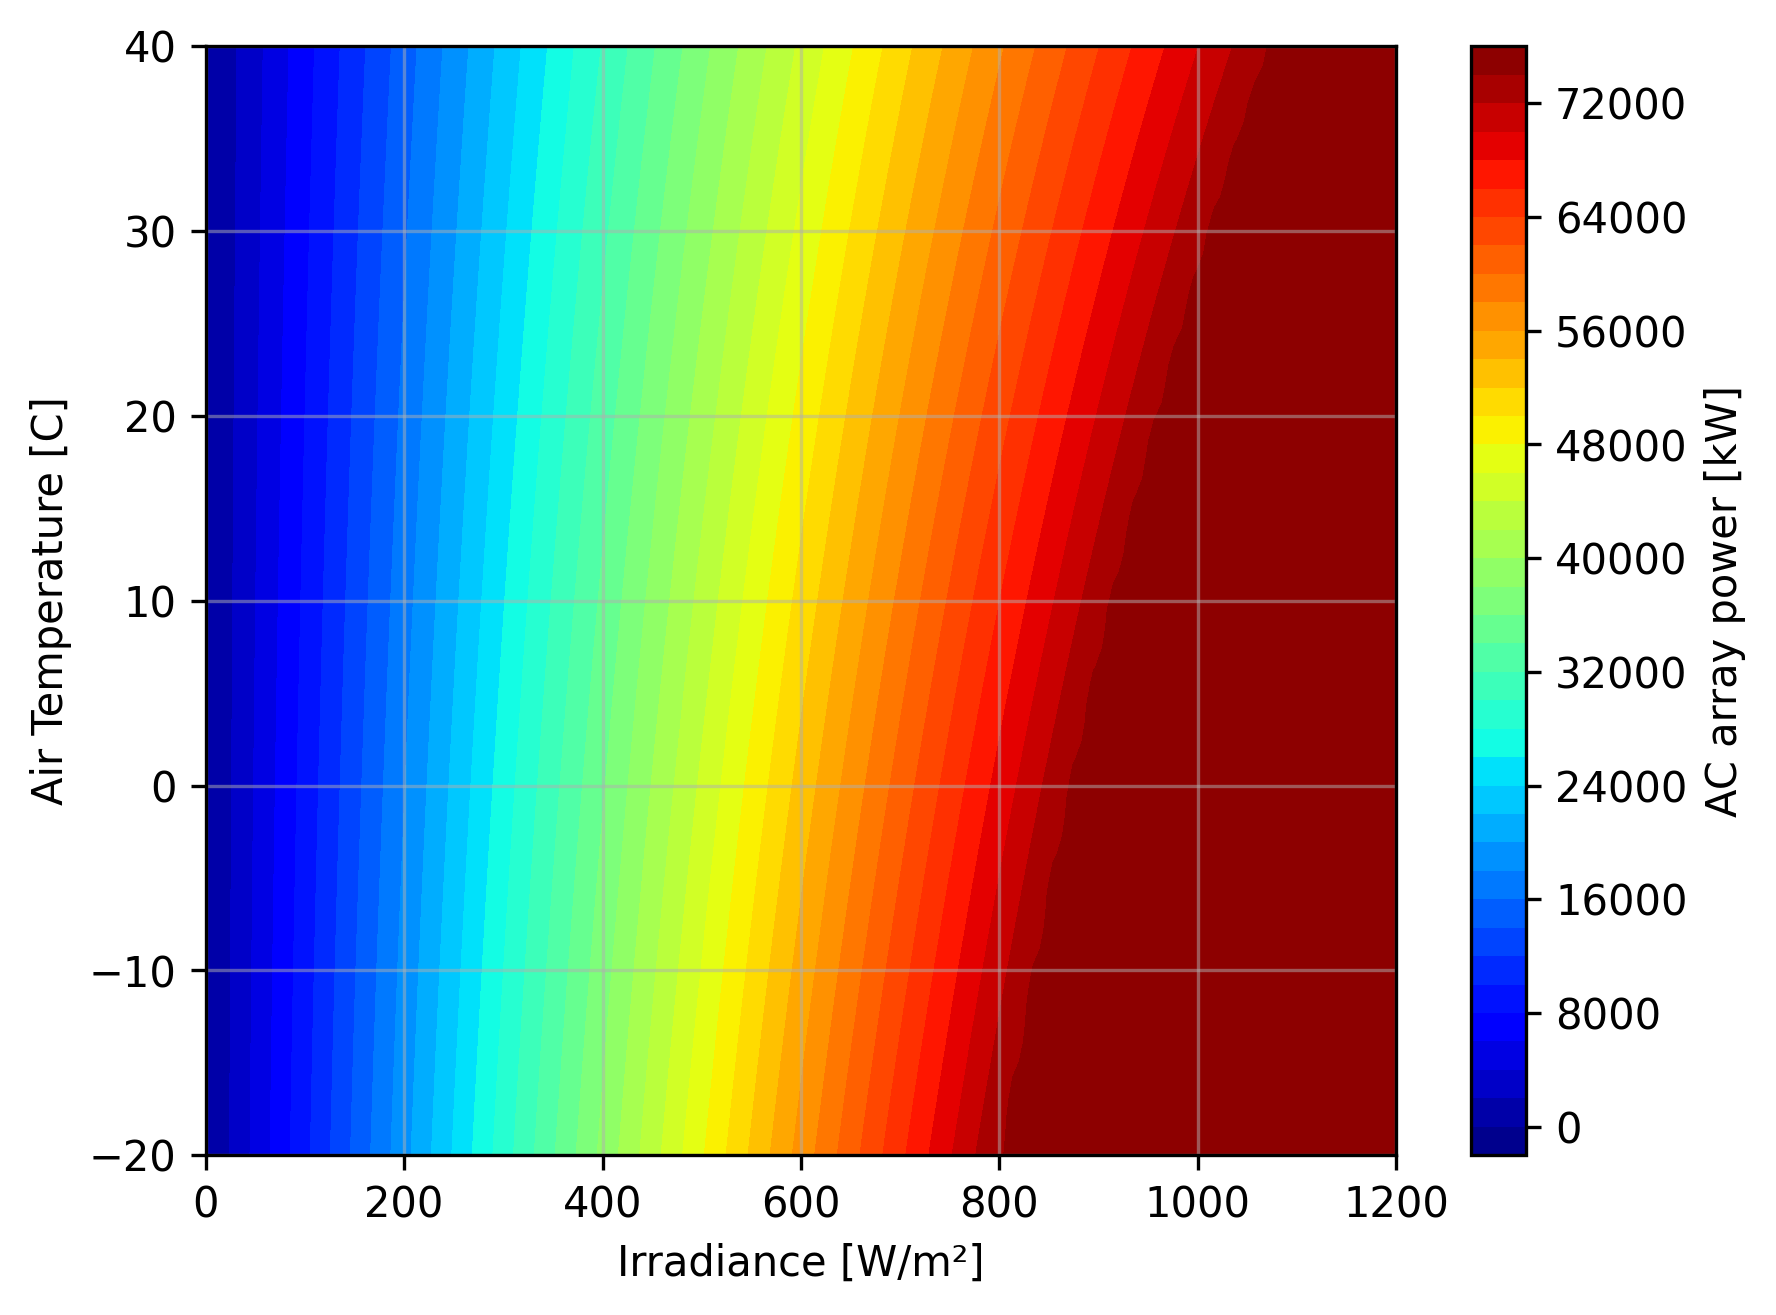

In [60]:
# contour plot
plt.figure(dpi=300)
plt.contourf(poas, air_temps, ac, 40, cmap='jet')

plt.colorbar(label='AC array power [kW]', ax=plt.gca())
# pc.set_alpha(0.25)
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Air Temperature [C]')
plt.show()

In [62]:
# create dictionary of data to export
data_export = np.empty((len(poas),len(air_temps)+2))
data_export[:,0] = poas
data_export[:,1] = air_temps
data_export[:,2:] = ac

np.save('data_export.npy', data_export)

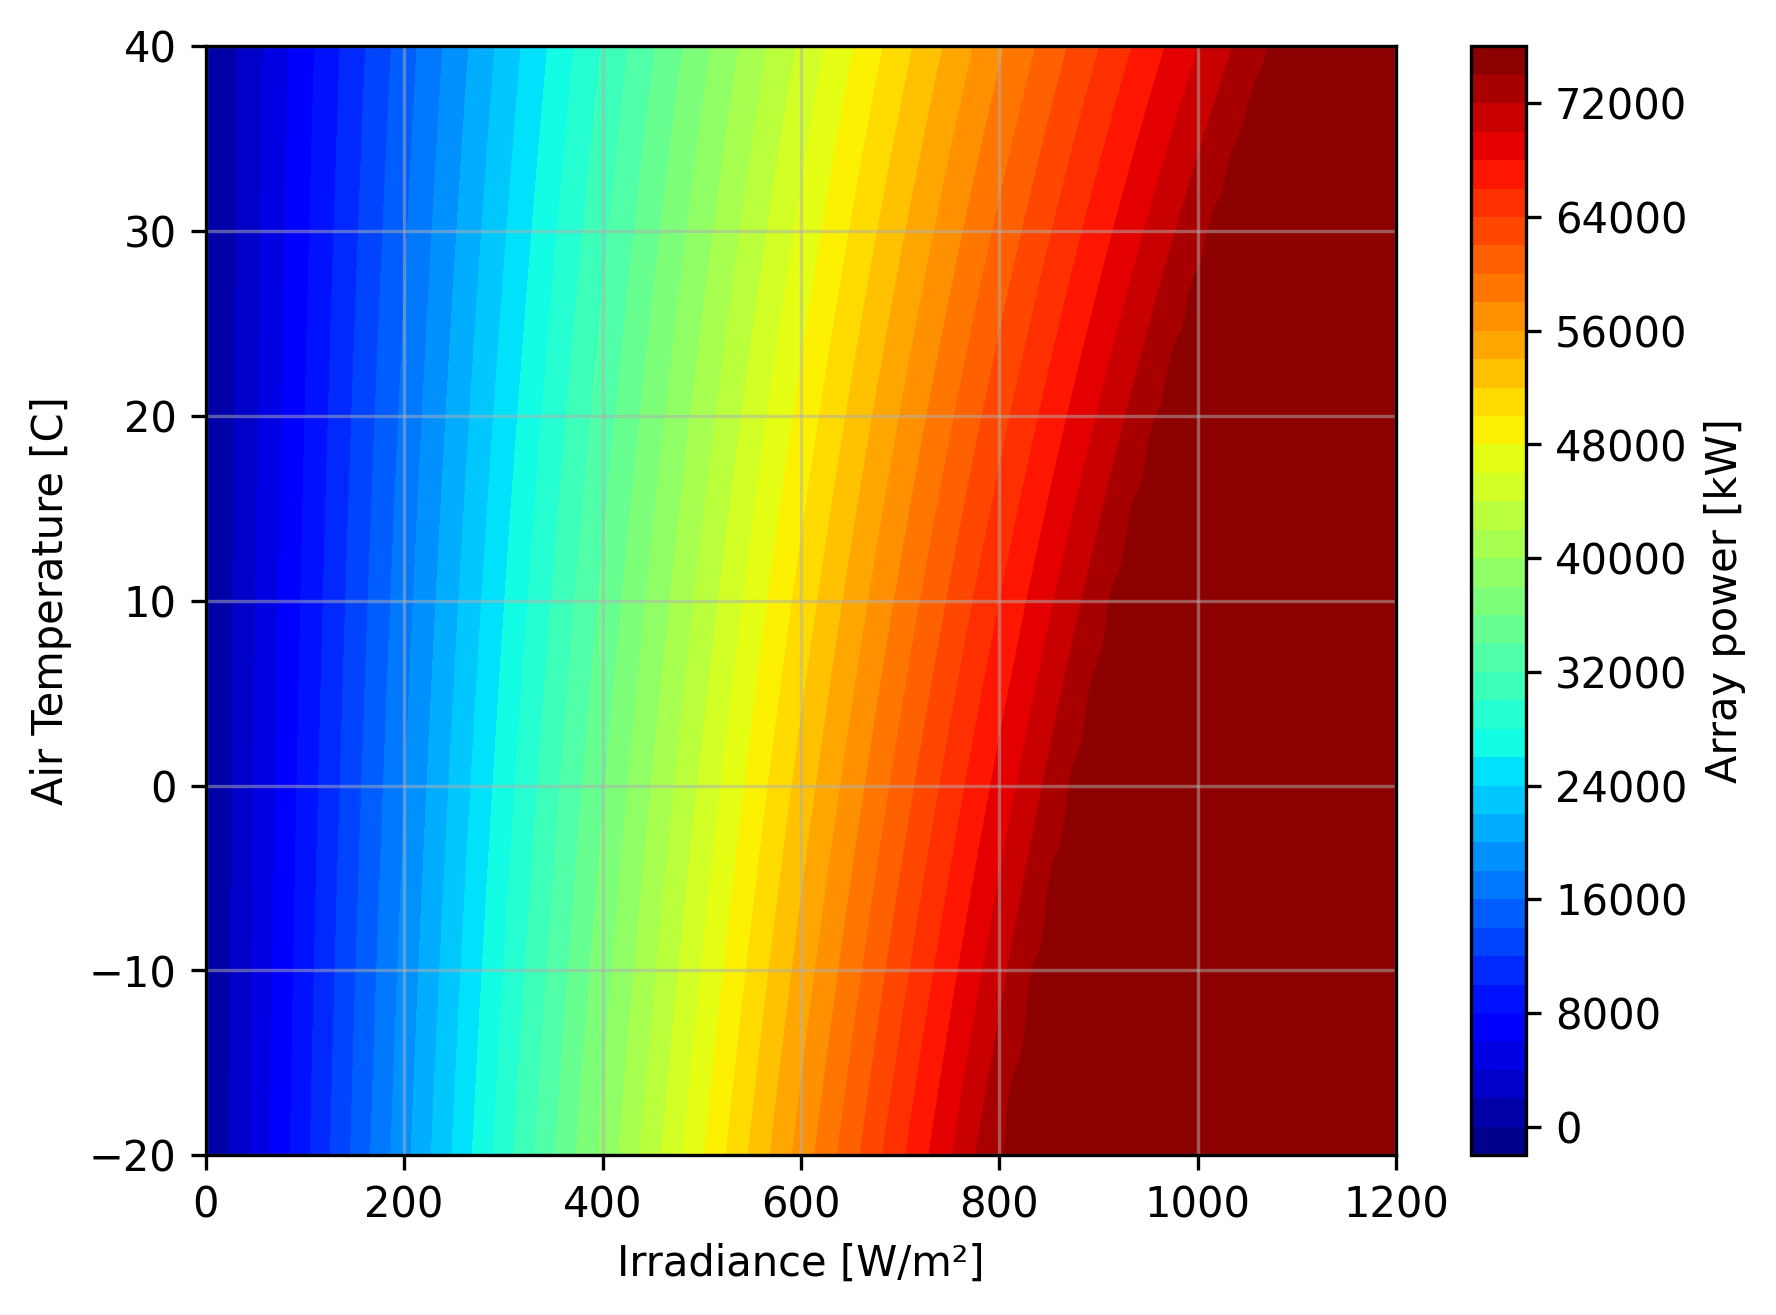

In [63]:
data_import = np.load('data_export.npy')

xt = data_export[:,0]
yt = data_export[:,1]
zt = data_export[:,2:]

plt.figure(dpi=300)
plt.contourf(xt, yt, zt, 40, cmap='jet')

plt.colorbar(label='Array power [kW]', ax=plt.gca())
plt.grid(alpha=0.5)
plt.xlabel('Irradiance [W/m²]')
plt.ylabel('Air Temperature [C]')
plt.show()